# Install and Import Required Packages

In [ ]:
!pip install split-folders

In [ ]:
!pip install tf-keras-vis

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 52.1/52.1 kB 6.1 MB/s eta 0:00:00


In [1]:
import os, shutil, pathlib
import cv2
import glob
import numpy as np
import pandas as pd
import math
import skimage
from PIL import Image
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import seaborn as sns
# import splitfolders

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, utils
from tensorflow.keras.utils import image_dataset_from_directory

# from tf_keras_vis.gradcam_plus_plus import GradcamPlusPlus
# from tf_keras_vis.utils.model_modifiers import ReplaceToLinear
# from tf_keras_vis.utils.scores import CategoricalScore
# from IPython.display import Image, display

# Dataset Demographics

## DME Status
The isHealthy function in the HEI GitHub repo defines "healthy" as cases where the .GND file for the sample does not contain any exudates or microaneurysms: https://github.com/lgiancaUTH/HEI-MED/blob/2d5b282e0f5c47d90b725855feb1f1e9f89b96eb/misc/Dmed.m#L118.

In [6]:
dir_path = '/content/drive/My Drive/HEI-MED/DMED'

health_dict = {}

# Images without exudates or microaneurysms are classed as healthy.
for file in glob.glob(dir_path+'/*.GND'):
    with open(file) as f:
        fstring = ' '.join(f.readlines())
        if ('Exudate' not in fstring) and ('MicroAneurysm' not in fstring):
          health_dict[file] = 'Healthy'
        else:
          health_dict[file] = 'DME'

In [7]:
df_health = pd.DataFrame.from_dict(health_dict, orient='index')
df_health = df_health.reset_index()
df_health = df_health.rename(columns={'index': 'File', 0: 'Status'})
df_health = df_health[['File', 'Status']]
df_health.head(2)

File Status
0  /content/drive/My Drive/HEI-MED/DMED/(00000003...    DME
1  /content/drive/My Drive/HEI-MED/DMED/(00000052...    DME

In [8]:
# Get file number
def get_file_number(filename):
    filename=filename.replace('/content/drive/My Drive/HEI-MED/DMED/', '')
    filename=filename.replace('.meta', '')
    filename=filename.replace('.jpg', '')
    filename=filename.replace('.GND', '')
    return filename

df_health['FileNumber']=df_health['File'].apply(lambda x: get_file_number(x))

In [9]:
# Get numbers and percentages of healthy vs DME individuals
print('Counts')
print(df_health['Status'].value_counts())
print('Percentages')
print(df_health['Status'].value_counts(normalize=True).mul(100).round(2).astype(str)+'%')

Counts
Healthy    109
DME         60
Name: Status, dtype: int64
Percentages
Healthy    64.5%
DME        35.5%
Name: Status, dtype: object


## Ethnicity

In [ ]:
def get_ethnicity(fpath):
    with open(fpath) as f:
        flist = f.readlines()
        if 'dcm.meta' in file:
          ethnicity = flist[4]
        else:
          ethnicity = flist[2]
        ethnicity = ethnicity.rstrip('\n')
        ethnicity = ethnicity.lstrip('~PatientRace~')
        return ethnicity

In [ ]:
dir_path = '/content/drive/My Drive/HEI-MED/DMED'
ethnicity_dict = {}
for file in glob.glob(dir_path+'/*.meta'):
  filenumber = get_file_number(file)
  ethnicity_dict[filenumber] = get_ethnicity(file)

In [ ]:
ethnicity_df = pd.DataFrame.from_dict(ethnicity_dict, orient='index')
ethnicity_df = ethnicity_df.reset_index()
ethnicity_df = ethnicity_df.rename(columns={'index': 'FileNumber', 0: 'Ethnicity'})
ethnicity_df.head(2)

FileNumber Ethnicity
0  (00000052)   AFRICAN
1  (00000053)   AFRICAN

In [ ]:
# Get numbers and percentages of healthy vs DME individuals
print('Counts')
print(ethnicity_df['Ethnicity'].value_counts())
print('Percentages')
print(ethnicity_df['Ethnicity'].value_counts(normalize=True).mul(100).round(2).astype(str)+'%')

Counts
AFRICAN      104
CAUCASIAN     42
HISPANIC      19
UNKNOWN        4
Name: Ethnicity, dtype: int64
Percentages
AFRICAN      61.54%
CAUCASIAN    24.85%
HISPANIC     11.24%
UNKNOWN       2.37%
Name: Ethnicity, dtype: object


## Ethnicity Distribution within DME/non-DME Groups

In [ ]:
df = df_health.merge(ethnicity_df, on='FileNumber')[['FileNumber', 'Status', 'Ethnicity']]
df.head(2)

FileNumber Status  Ethnicity
0  (00000003)    DME  CAUCASIAN
1  (00000052)    DME    AFRICAN

In [ ]:
df.to_csv('/content/drive/My Drive/MSc Data Science/Dissertation/Data/HEI-MED/hei_info.csv')

In [ ]:
# Get numbers and percentages of healthy vs DME individuals
print('DME')
print('Counts')
print(df[df['Status']=='DME']['Ethnicity'].value_counts())
print('Percentages')
print(df[df['Status']=='DME']['Ethnicity'].value_counts(normalize=True).mul(100).round(2).astype(str)+'%')

DME
Counts
AFRICAN      47
CAUCASIAN     7
HISPANIC      3
UNKNOWN       3
Name: Ethnicity, dtype: int64
Percentages
AFRICAN      78.33%
CAUCASIAN    11.67%
HISPANIC       5.0%
UNKNOWN        5.0%
Name: Ethnicity, dtype: object


In [ ]:
# Get numbers and percentages of healthy vs DME individuals
print('Healthy')
print('Counts')
print(df[df['Status']=='Healthy']['Ethnicity'].value_counts())
print('Percentages')
print(df[df['Status']=='Healthy']['Ethnicity'].value_counts(normalize=True).mul(100).round(2).astype(str)+'%')

Healthy
Counts
AFRICAN      57
CAUCASIAN    35
HISPANIC     16
UNKNOWN       1
Name: Ethnicity, dtype: int64
Percentages
AFRICAN      52.29%
CAUCASIAN    32.11%
HISPANIC     14.68%
UNKNOWN       0.92%
Name: Ethnicity, dtype: object


# Image Pre-Processing

## Move images into ethnicity folders

In [ ]:
os.mkdir('/content/drive/My Drive/MSc Data Science/Dissertation/Data/HEI-MED/')
os.mkdir('/content/drive/My Drive/MSc Data Science/Dissertation/Data/HEI-MED/processed-data/')
os.mkdir('/content/drive/My Drive/MSc Data Science/Dissertation/Data/HEI-MED/processed-data/AFRICAN')
os.mkdir('/content/drive/My Drive/MSc Data Science/Dissertation/Data/HEI-MED/processed-data/CAUCASIAN')
os.mkdir('/content/drive/My Drive/MSc Data Science/Dissertation/Data/HEI-MED/processed-data/HISPANIC')
os.mkdir('/content/drive/My Drive/MSc Data Science/Dissertation/Data/HEI-MED/processed-data/UNKNOWN')

In [ ]:
for filenum in ethnicity_df['FileNumber']:
  ethnicity = ethnicity_df[ethnicity_df['FileNumber']==filenum].Ethnicity.item()
  srcpath = '/content/drive/My Drive/HEI-MED/DMED/{}.jpg'.format(filenum)
  destpath = '/content/drive/My Drive/MSc Data Science/Dissertation/Data/HEI-MED/processed-data/{}/{}.jpg'.format(ethnicity, filenum)
  shutil.copyfile(srcpath, destpath)

In [ ]:
print('AFRICAN:', len(os.listdir('/content/drive/My Drive/MSc Data Science/Dissertation/Data/HEI-MED/processed-data/AFRICAN')), 'SAMPLES')
print('CAUCASIAN:', len(os.listdir('/content/drive/My Drive/MSc Data Science/Dissertation/Data/HEI-MED/processed-data/CAUCASIAN')), 'SAMPLES')
print('HISPANIC:', len(os.listdir('/content/drive/My Drive/MSc Data Science/Dissertation/Data/HEI-MED/processed-data/HISPANIC')), 'SAMPLES')
print('UNKNOWN:', len(os.listdir('/content/drive/My Drive/MSc Data Science/Dissertation/Data/HEI-MED/processed-data/UNKNOWN')), 'SAMPLES')

AFRICAN: 104 SAMPLES
CAUCASIAN: 42 SAMPLES
HISPANIC: 19 SAMPLES
UNKNOWN: 4 SAMPLES


## Crop and resize images

In [ ]:
# Citation needed
def circle_crop_v2(img):
    """
    Create circular crop around image centre
    """
    img = cv2.imread(img)

    height, width, depth = img.shape
    largest_side = np.max((height, width))
    img = cv2.resize(img, (largest_side, largest_side))

    height, width, depth = img.shape

    x = int(width / 2)
    y = int(height / 2)
    r = np.amin((x, y))

    circle_img = np.zeros((height, width), np.uint8)
    cv2.circle(circle_img, (x, y), int(r), 1, thickness=-1)
    img = cv2.bitwise_and(img, img, mask=circle_img)

    new_size = int(largest_side/4)
    img = cv2.resize(img, (new_size, new_size)) # Make image smaller

    return img

In [ ]:
base_dir = '/content/drive/My Drive/MSc Data Science/Dissertation/Data/HEI-MED/processed-data/'
level_1 = ['AFRICAN', 'CAUCASIAN', 'HISPANIC', 'UNKNOWN']

for dir1 in level_1:
  for img in os.listdir(os.path.join(base_dir, dir1)):
    new_img = circle_crop_v2(os.path.join(base_dir, dir1, img))
    cv2.imwrite(os.path.join(base_dir, dir1, img), new_img)

In [ ]:
print('AFRICAN:', len(os.listdir('/content/drive/My Drive/MSc Data Science/Dissertation/Data/HEI-MED/processed-data/AFRICAN')), 'SAMPLES')
print('CAUCASIAN:', len(os.listdir('/content/drive/My Drive/MSc Data Science/Dissertation/Data/HEI-MED/processed-data/CAUCASIAN')), 'SAMPLES')
print('HISPANIC:', len(os.listdir('/content/drive/My Drive/MSc Data Science/Dissertation/Data/HEI-MED/processed-data/HISPANIC')), 'SAMPLES')
print('UNKNOWN:', len(os.listdir('/content/drive/My Drive/MSc Data Science/Dissertation/Data/HEI-MED/processed-data/UNKNOWN')), 'SAMPLES')

AFRICAN: 104 SAMPLES
CAUCASIAN: 42 SAMPLES
HISPANIC: 19 SAMPLES
UNKNOWN: 4 SAMPLES


# Individual Typology Angle (ITA)

## Pixelwise ITA Method

In [ ]:
# # Calculate mean pixelwise ITA

def mean_pixelwise_ita_no_black_pixels(lab):
  ita_array = []

  for j in range(0, lab.shape[1]):
    for i in range(0, lab.shape[0]):
      # Luminance
      l = lab[i, j, 0]
      if l != 0:
        # b
        b = lab[i, j, 2]
        # ITA
        ita = math.atan2(l - 50, b) * (180 / np.pi)
        # Add to array
        ita_array.append(ita)

  # Return mean value
  return np.array(ita_array).mean()

## Calculate ITA for all images

In [ ]:
# Get file number
def get_file_number(filename):
    filename=filename.replace('/content/drive/My Drive/MSc Data Science/Dissertation/Data/HEI-MED/processed-data/', '')
    filename=filename.replace('AFRICAN/', '')
    filename=filename.replace('CAUCASIAN/', '')
    filename=filename.replace('HISPANIC/', '')
    filename=filename.replace('UKNOWN/', '')
    filename=filename.replace('.meta', '')
    filename=filename.replace('.jpg', '')
    filename=filename.replace('.GND', '')
    return filename

In [ ]:
# AFRICAN
ita_dict = {}

for file in glob.glob('/content/drive/My Drive/MSc Data Science/Dissertation/Data/HEI-MED/processed-data/AFRICAN/*.jpg'):
  # Get file number
  file_number = get_file_number(file)
  # Convert to LAB colour space
  lab = skimage.color.rgb2lab(Image.open(file))
  # Calculate ITA
  ita = mean_pixelwise_ita_no_black_pixels(lab)
  # Add to dictionary
  ita_dict[file_number] = ita

In [ ]:
african_ita_df = pd.DataFrame.from_dict(ita_dict, orient='index')
african_ita_df = african_ita_df.reset_index()
african_ita_df = african_ita_df.rename(columns={'index': 'Sample', 0: 'ITA'})
african_ita_df['Ethnicity'] = 'AFRICAN'
african_ita_df.head(2)

Sample        ITA Ethnicity
0  (00000052) -52.301036   AFRICAN
1  (00000105) -63.121285   AFRICAN

In [ ]:
# CAUCASIAN
ita_dict = {}

for file in glob.glob('/content/drive/My Drive/MSc Data Science/Dissertation/Data/HEI-MED/processed-data/CAUCASIAN/*.jpg'):
  # Get file number
  file_number = get_file_number(file)
  # Convert to LAB colour space
  lab = skimage.color.rgb2lab(Image.open(file))
  # Calculate ITA
  ita = mean_pixelwise_ita_no_black_pixels(lab)
  # Add to dictionary
  ita_dict[file_number] = ita

In [ ]:
caucasian_ita_df = pd.DataFrame.from_dict(ita_dict, orient='index')
caucasian_ita_df = caucasian_ita_df.reset_index()
caucasian_ita_df = caucasian_ita_df.rename(columns={'index': 'Sample', 0: 'ITA'})
caucasian_ita_df['Ethnicity'] = 'CAUCASIAN'
caucasian_ita_df.head(2)

Sample        ITA  Ethnicity
0  (00000174) -25.743830  CAUCASIAN
1  (00000003) -71.324543  CAUCASIAN

In [ ]:
# HISPANIC
ita_dict = {}

for file in glob.glob('/content/drive/My Drive/MSc Data Science/Dissertation/Data/HEI-MED/processed-data/HISPANIC/*.jpg'):
  # Get file number
  file_number = get_file_number(file)
  # Convert to LAB colour space
  lab = skimage.color.rgb2lab(Image.open(file))
  # Calculate ITA
  ita = mean_pixelwise_ita_no_black_pixels(lab)
  # Add to dictionary
  ita_dict[file_number] = ita

In [ ]:
hispanic_ita_df = pd.DataFrame.from_dict(ita_dict, orient='index')
hispanic_ita_df = hispanic_ita_df.reset_index()
hispanic_ita_df = hispanic_ita_df.rename(columns={'index': 'Sample', 0: 'ITA'})
hispanic_ita_df['Ethnicity'] = 'HISPANIC'
hispanic_ita_df.head(2)

Sample        ITA Ethnicity
0  (00000054) -58.513172  HISPANIC
1  (00000055) -56.113927  HISPANIC

In [ ]:
# UNKNOWN
ita_dict = {}

for file in glob.glob('/content/drive/My Drive/MSc Data Science/Dissertation/Data/HEI-MED/processed-data/UNKNOWN/*.jpg'):
  # Get file number
  file_number = get_file_number(file)
  # Convert to LAB colour space
  lab = skimage.color.rgb2lab(Image.open(file))
  # Calculate ITA
  ita = mean_pixelwise_ita_no_black_pixels(lab)
  # Add to dictionary
  ita_dict[file_number] = ita

In [ ]:
unknown_ita_df = pd.DataFrame.from_dict(ita_dict, orient='index')
unknown_ita_df = unknown_ita_df.reset_index()
unknown_ita_df = unknown_ita_df.rename(columns={'index': 'Sample', 0: 'ITA'})
unknown_ita_df['Ethnicity'] = 'UNKNOWN'
unknown_ita_df.head(2)

Sample        ITA Ethnicity
0  UNKNOWN/(00000094) -31.063716   UNKNOWN
1  UNKNOWN/(00000256) -43.067883   UNKNOWN

In [ ]:
ita_df = pd.concat([african_ita_df, caucasian_ita_df, hispanic_ita_df, unknown_ita_df])
ita_df.head()

Sample        ITA Ethnicity
0  (00000052) -52.301036   AFRICAN
1  (00000105) -63.121285   AFRICAN
2  (00000053) -53.446908   AFRICAN
3  (00000061) -22.811277   AFRICAN
4  (00000074) -54.924219   AFRICAN

## Plot ITA Distributions

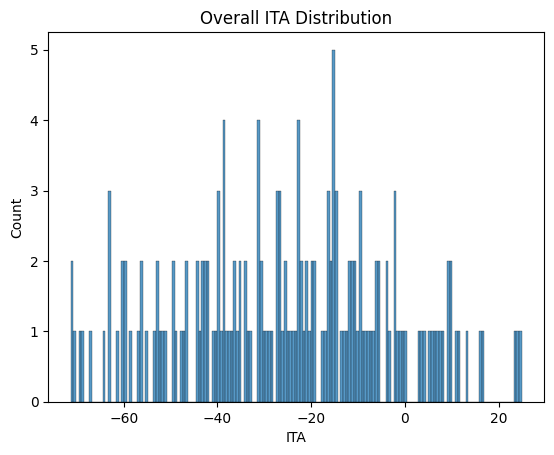

In [ ]:
sns.histplot(data=ita_df, x='ITA', bins=169)
plt.title('Overall ITA Distribution')
plt.show()

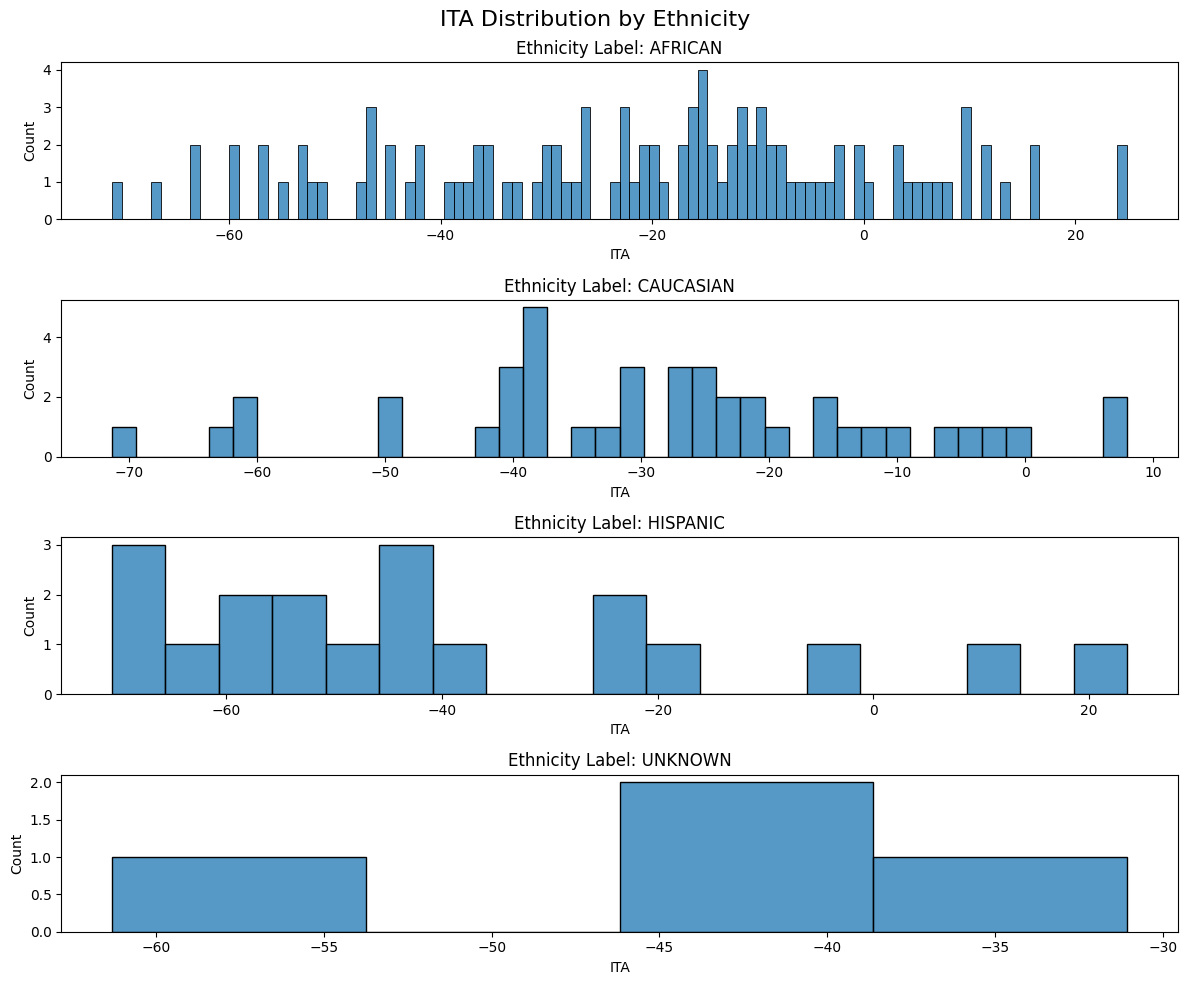

In [ ]:
fig, ax = plt.subplots(4, 1, figsize=(12,10))

sns.histplot(data=ita_df[ita_df['Ethnicity']=='AFRICAN'], x='ITA', bins=104, ax=ax[0])
ax[0].set_title('Ethnicity Label: AFRICAN', fontsize=12)

sns.histplot(data=ita_df[ita_df['Ethnicity']=='CAUCASIAN'], x='ITA', bins=42, ax=ax[1])
ax[1].set_title('Ethnicity Label: CAUCASIAN', fontsize=12)

sns.histplot(data=ita_df[ita_df['Ethnicity']=='HISPANIC'], x='ITA', bins=19, ax=ax[2])
ax[2].set_title('Ethnicity Label: HISPANIC', fontsize=12)

sns.histplot(data=ita_df[ita_df['Ethnicity']=='UNKNOWN'], x='ITA', bins=4, ax=ax[3])
ax[3].set_title('Ethnicity Label: UNKNOWN', fontsize=12)

fig.suptitle('ITA Distribution by Ethnicity', fontsize=16)

plt.tight_layout()
plt.show()

In [ ]:
for ethnicity in ['AFRICAN', 'CAUCASIAN', 'HISPANIC', 'UNKNOWN']:
  print(ethnicity+':')
  print('Mean ITA: {}, SD: {}'.format(round(ita_df[ita_df['Ethnicity']==ethnicity]['ITA'].mean(), 2), round(ita_df[ita_df['Ethnicity']==ethnicity]['ITA'].std(), 2)))

AFRICAN:
Mean ITA: -20.82, SD: 21.99
CAUCASIAN:
Mean ITA: -28.55, SD: 18.18
HISPANIC:
Mean ITA: -39.01, SD: 26.8
UNKNOWN:
Mean ITA: -43.79, SD: 12.73


## Healthy Samples Only

In [ ]:
df_health = df_health.rename(columns={'FileNumber': 'Sample'})
ita_df = ita_df.merge(df_health, on='Sample')
ita_df = ita_df[['Sample', 'Ethnicity', 'Status', 'ITA']]
ita_df.head(2)

Sample Ethnicity Status        ITA
0  (00000052)   AFRICAN    DME -52.301036
1  (00000105)   AFRICAN    DME -63.121285

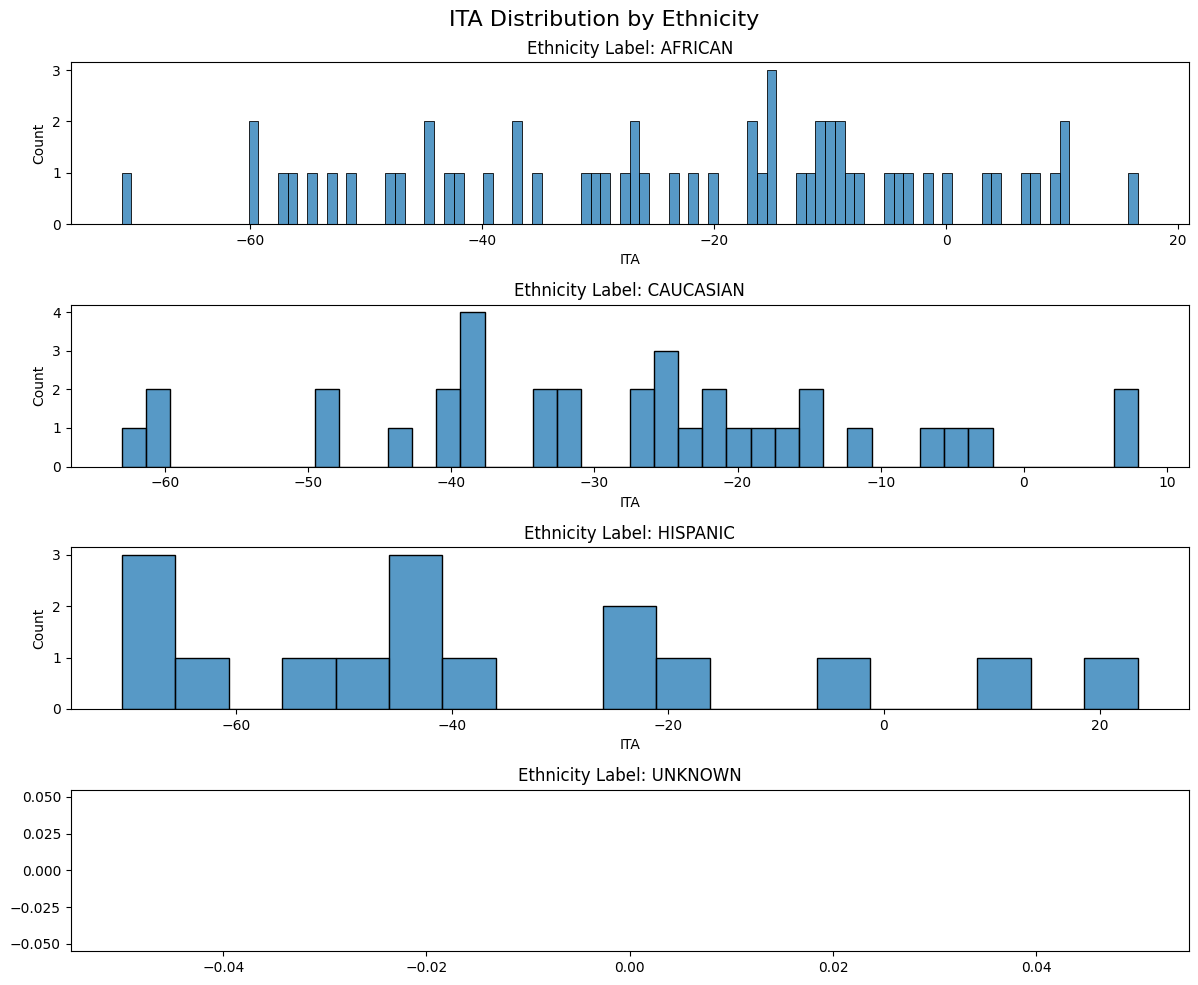

In [ ]:
fig, ax = plt.subplots(4, 1, figsize=(12,10))

healthy_samples = ita_df[ita_df['Status']=='Healthy']

sns.histplot(data=healthy_samples[healthy_samples['Ethnicity']=='AFRICAN'], x='ITA', bins=104, ax=ax[0])
ax[0].set_title('Ethnicity Label: AFRICAN', fontsize=12)

sns.histplot(data=healthy_samples[healthy_samples['Ethnicity']=='CAUCASIAN'], x='ITA', bins=42, ax=ax[1])
ax[1].set_title('Ethnicity Label: CAUCASIAN', fontsize=12)

sns.histplot(data=healthy_samples[healthy_samples['Ethnicity']=='HISPANIC'], x='ITA', bins=19, ax=ax[2])
ax[2].set_title('Ethnicity Label: HISPANIC', fontsize=12)

sns.histplot(data=healthy_samples[healthy_samples['Ethnicity']=='UNKNOWN'], x='ITA', bins=4, ax=ax[3])
ax[3].set_title('Ethnicity Label: UNKNOWN', fontsize=12)

fig.suptitle('ITA Distribution by Ethnicity', fontsize=16)

plt.tight_layout()
plt.show()

# Mean Luminance

## Calculate mean luminance for all images

In [ ]:
# AFRICAN
lum_dict = {}

for file in glob.glob('/content/drive/My Drive/MSc Data Science/Dissertation/Data/HEI-MED/processed-data/AFRICAN/*.jpg'):
  # Get file number
  file_number = get_file_number(file)
  # Convert to LAB colour space
  lab = skimage.color.rgb2lab(Image.open(file))
  # Get luminance values
  lum = lab[:,:,0].ravel()
  # Remove pixels with zero luminance
  lum_ind_no_zeros = np.array(np.where(lum!=0))
  lum_no_zeros = lum[lum_ind_no_zeros][0]
  # Add to dictionary
  lum_dict[file_number] = lum_no_zeros.mean()

In [ ]:
african_lum_df = pd.DataFrame.from_dict(lum_dict, orient='index')
african_lum_df = african_lum_df.reset_index()
african_lum_df = african_lum_df.rename(columns={'index': 'Sample', 0: 'Mean Luminance'})
african_lum_df['Ethnicity'] = 'AFRICAN'
african_lum_df.head(2)

Sample  Mean Luminance Ethnicity
0  (00000052)       25.801376   AFRICAN
1  (00000105)       26.828866   AFRICAN

In [ ]:
# CAUCASIAN
lum_dict = {}

for file in glob.glob('/content/drive/My Drive/MSc Data Science/Dissertation/Data/HEI-MED/processed-data/CAUCASIAN/*.jpg'):
  # Get file number
  file_number = get_file_number(file)
  # Convert to LAB colour space
  lab = skimage.color.rgb2lab(Image.open(file))
  # Get luminance values
  lum = lab[:,:,0].ravel()
  # Remove pixels with zero luminance
  lum_ind_no_zeros = np.array(np.where(lum!=0))
  lum_no_zeros = lum[lum_ind_no_zeros][0]
  # Add to dictionary
  lum_dict[file_number] = lum_no_zeros.mean()

In [ ]:
caucasian_lum_df = pd.DataFrame.from_dict(lum_dict, orient='index')
caucasian_lum_df = caucasian_lum_df.reset_index()
caucasian_lum_df = caucasian_lum_df.rename(columns={'index': 'Sample', 0: 'Mean Luminance'})
caucasian_lum_df['Ethnicity'] = 'CAUCASIAN'
caucasian_lum_df.head(2)

Sample  Mean Luminance  Ethnicity
0  (00000174)       37.605239  CAUCASIAN
1  (00000003)       14.882945  CAUCASIAN

In [ ]:
# HISPANIC
lum_dict = {}

for file in glob.glob('/content/drive/My Drive/MSc Data Science/Dissertation/Data/HEI-MED/processed-data/HISPANIC/*.jpg'):
  # Get file number
  file_number = get_file_number(file)
  # Convert to LAB colour space
  lab = skimage.color.rgb2lab(Image.open(file))
  # Get luminance values
  lum = lab[:,:,0].ravel()
  # Remove pixels with zero luminance
  lum_ind_no_zeros = np.array(np.where(lum!=0))
  lum_no_zeros = lum[lum_ind_no_zeros][0]
  # Add to dictionary
  lum_dict[file_number] = lum_no_zeros.mean()

In [ ]:
hispanic_lum_df = pd.DataFrame.from_dict(lum_dict, orient='index')
hispanic_lum_df = hispanic_lum_df.reset_index()
hispanic_lum_df = hispanic_lum_df.rename(columns={'index': 'Sample', 0: 'Mean Luminance'})
hispanic_lum_df['Ethnicity'] = 'HISPANIC'
hispanic_lum_df.head(2)

Sample  Mean Luminance Ethnicity
0  (00000054)       22.303892  HISPANIC
1  (00000055)       24.165587  HISPANIC

In [ ]:
# UNKNOWN
lum_dict = {}

for file in glob.glob('/content/drive/My Drive/MSc Data Science/Dissertation/Data/HEI-MED/processed-data/UNKNOWN/*.jpg'):
  # Get file number
  file_number = get_file_number(file)
  # Convert to LAB colour space
  lab = skimage.color.rgb2lab(Image.open(file))
  # Get luminance values
  lum = lab[:,:,0].ravel()
  # Remove pixels with zero luminance
  lum_ind_no_zeros = np.array(np.where(lum!=0))
  lum_no_zeros = lum[lum_ind_no_zeros][0]
  # Add to dictionary
  lum_dict[file_number] = lum_no_zeros.mean()

In [ ]:
unknown_lum_df = pd.DataFrame.from_dict(lum_dict, orient='index')
unknown_lum_df = unknown_lum_df.reset_index()
unknown_lum_df = unknown_lum_df.rename(columns={'index': 'Sample', 0: 'Mean Luminance'})
unknown_lum_df['Ethnicity'] = 'UNKNOWN'
unknown_lum_df.head(2)

Sample  Mean Luminance Ethnicity
0  UNKNOWN/(00000094)       34.946865   UNKNOWN
1  UNKNOWN/(00000256)       31.097074   UNKNOWN

In [ ]:
lum_df = pd.concat([african_lum_df, caucasian_lum_df, hispanic_lum_df, unknown_lum_df])
lum_df.head(2)

Sample  Mean Luminance Ethnicity
0  (00000052)       25.801376   AFRICAN
1  (00000105)       26.828866   AFRICAN

## Plot Mean Luminance Distributions

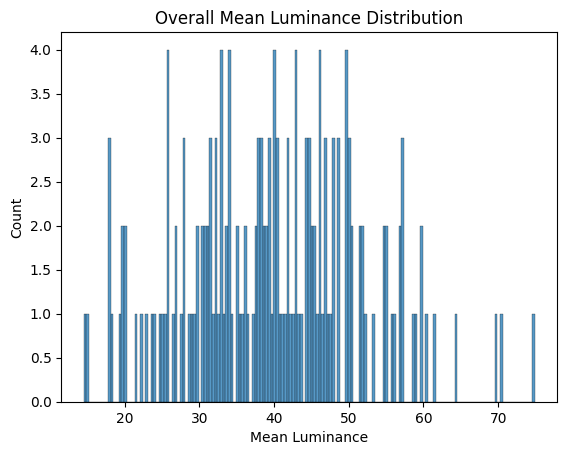

In [ ]:
sns.histplot(data=lum_df, x='Mean Luminance', bins=169)
plt.title('Overall Mean Luminance Distribution')
plt.show()

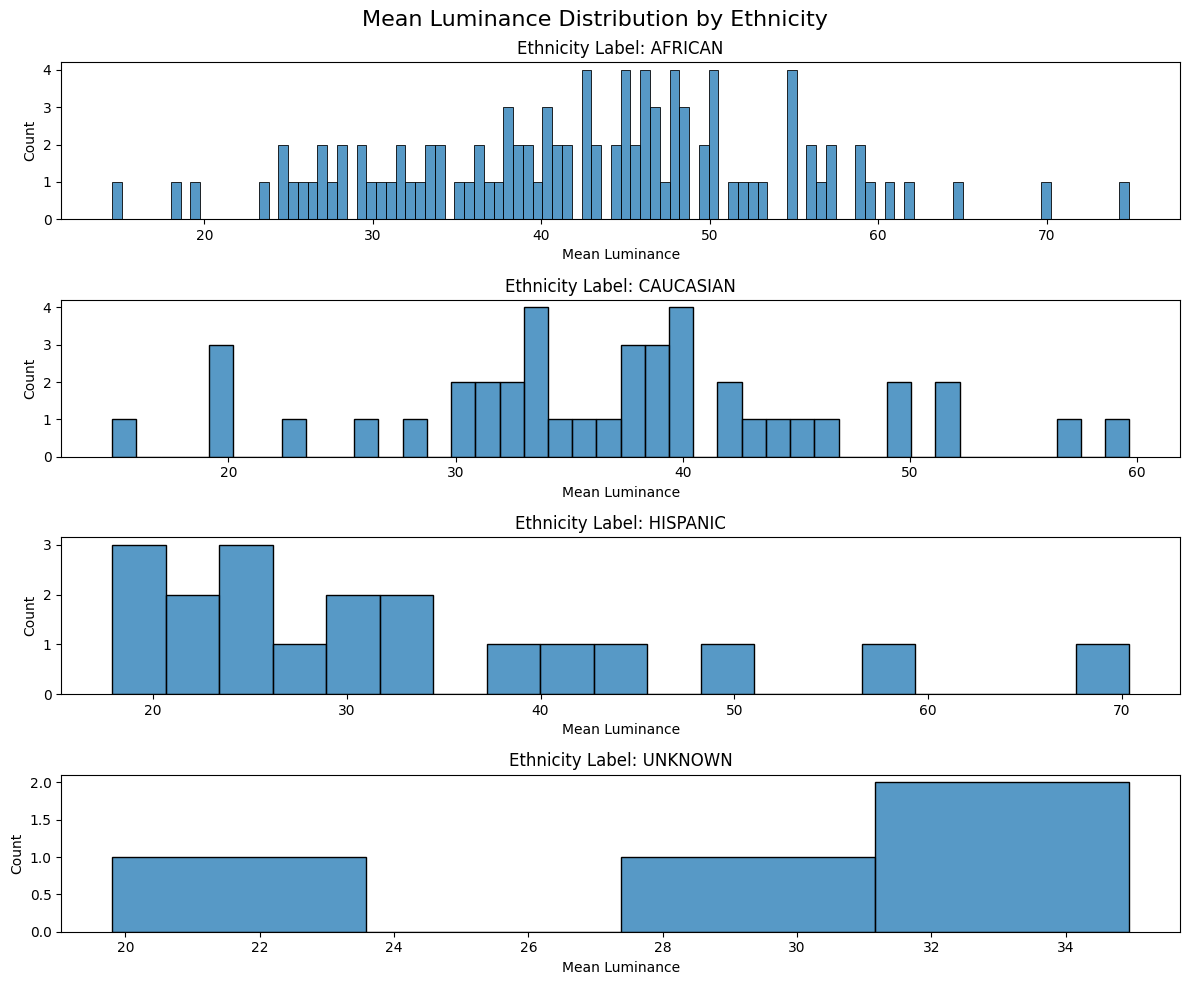

In [ ]:
fig, ax = plt.subplots(4, 1, figsize=(12,10))

sns.histplot(data=lum_df[lum_df['Ethnicity']=='AFRICAN'], x='Mean Luminance', bins=104, ax=ax[0])
ax[0].set_title('Ethnicity Label: AFRICAN', fontsize=12)

sns.histplot(data=lum_df[lum_df['Ethnicity']=='CAUCASIAN'], x='Mean Luminance', bins=42, ax=ax[1])
ax[1].set_title('Ethnicity Label: CAUCASIAN', fontsize=12)

sns.histplot(data=lum_df[lum_df['Ethnicity']=='HISPANIC'], x='Mean Luminance', bins=19, ax=ax[2])
ax[2].set_title('Ethnicity Label: HISPANIC', fontsize=12)

sns.histplot(data=lum_df[lum_df['Ethnicity']=='UNKNOWN'], x='Mean Luminance', bins=4, ax=ax[3])
ax[3].set_title('Ethnicity Label: UNKNOWN', fontsize=12)

fig.suptitle('Mean Luminance Distribution by Ethnicity', fontsize=16)

plt.tight_layout()
plt.show()

In [ ]:
for ethnicity in ['AFRICAN', 'CAUCASIAN', 'HISPANIC', 'UNKNOWN']:
  print(ethnicity+':')
  print('Mean ML Value: {}, SD: {}'.format(round(lum_df[lum_df['Ethnicity']==ethnicity]['Mean Luminance'].mean(), 2), round(lum_df[lum_df['Ethnicity']==ethnicity]['Mean Luminance'].std(), 2)))

AFRICAN:
Mean ML Value: 42.45, SD: 11.37
CAUCASIAN:
Mean ML Value: 36.96, SD: 9.91
HISPANIC:
Mean ML Value: 33.27, SD: 14.29
UNKNOWN:
Mean ML Value: 29.53, SD: 6.68


## Healthy Samples Only

In [ ]:
lum_df = lum_df.merge(df_health, on='Sample')
lum_df = lum_df[['Sample', 'Ethnicity', 'Status', 'Mean Luminance']]
lum_df.head(2)

Sample Ethnicity Status  Mean Luminance
0  (00000052)   AFRICAN    DME       25.801376
1  (00000105)   AFRICAN    DME       26.828866

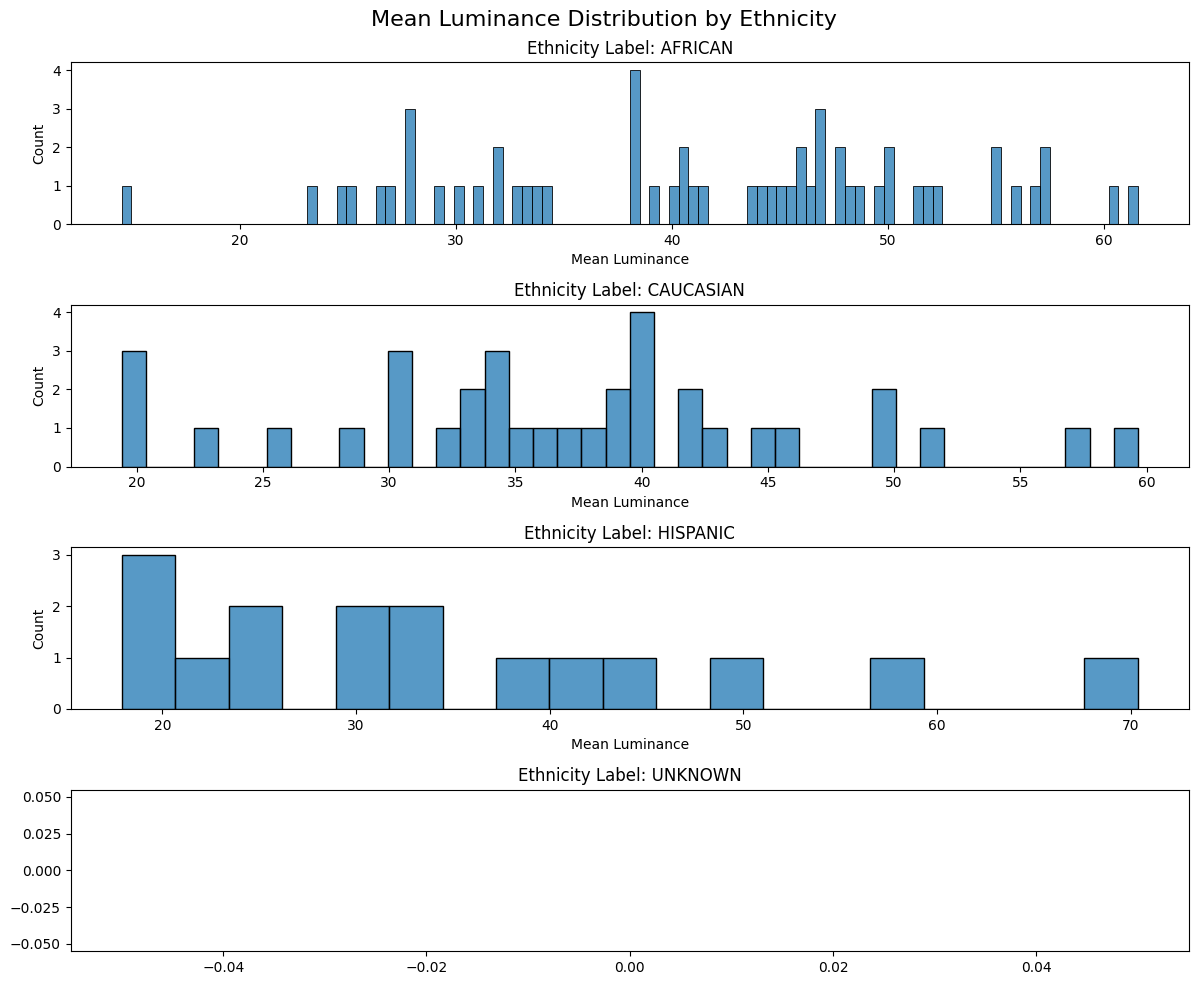

In [ ]:
fig, ax = plt.subplots(4, 1, figsize=(12,10))

healthy_samples = lum_df[lum_df['Status']=='Healthy']

sns.histplot(data=healthy_samples[healthy_samples['Ethnicity']=='AFRICAN'], x='Mean Luminance', bins=104, ax=ax[0])
ax[0].set_title('Ethnicity Label: AFRICAN', fontsize=12)

sns.histplot(data=healthy_samples[healthy_samples['Ethnicity']=='CAUCASIAN'], x='Mean Luminance', bins=42, ax=ax[1])
ax[1].set_title('Ethnicity Label: CAUCASIAN', fontsize=12)

sns.histplot(data=healthy_samples[healthy_samples['Ethnicity']=='HISPANIC'], x='Mean Luminance', bins=19, ax=ax[2])
ax[2].set_title('Ethnicity Label: HISPANIC', fontsize=12)

sns.histplot(data=healthy_samples[healthy_samples['Ethnicity']=='UNKNOWN'], x='Mean Luminance', bins=4, ax=ax[3])
ax[3].set_title('Ethnicity Label: UNKNOWN', fontsize=12)

fig.suptitle('Mean Luminance Distribution by Ethnicity', fontsize=16)

plt.tight_layout()
plt.show()

# Set random seed for training models

In [ ]:
tf.random.set_seed(1234)

# Ethnicity Classifier - Binary (African/Caucasian)

## Split images into train, val, and test

In [ ]:
os.mkdir('/content/drive/My Drive/MSc Data Science/Dissertation/Data/HEI-MED/ethnicity-classifier/')

In [ ]:
indir = '/content/drive/My Drive/MSc Data Science/Dissertation/Data/HEI-MED/processed-data/'
outdir = '/content/drive/My Drive/MSc Data Science/Dissertation/Data/HEI-MED/ethnicity-classifier/'

In [ ]:
splitfolders.ratio(indir, output=outdir,
    seed=1337, ratio=(.8, .1, .1), group_prefix=None, move=False)

Copying files: 169 files [00:02, 64.95 files/s]


In [ ]:
for folder in os.listdir(outdir):
  print(folder)
  for ethnicity in os.listdir(os.path.join(outdir, folder)):
    print(ethnicity + ': ' + str(len(os.listdir(os.path.join(outdir, folder, ethnicity)))) + ' samples')

train
AFRICAN: 83 samples
CAUCASIAN: 33 samples
HISPANIC: 15 samples
UNKNOWN: 3 samples
val
AFRICAN: 10 samples
CAUCASIAN: 4 samples
HISPANIC: 1 samples
UNKNOWN: 0 samples
test
AFRICAN: 11 samples
CAUCASIAN: 5 samples
HISPANIC: 3 samples
UNKNOWN: 1 samples


## Read in train, val and test sets
Removed Unknown and Hispanic - this will be a binary classification between African and Caucasian.

In [ ]:
new_base_dir = pathlib.Path('/content/drive/My Drive/MSc Data Science/Dissertation/Data/HEI-MED/ethnicity-classifier/')

train_dataset = image_dataset_from_directory(
    new_base_dir / 'train',
    image_size=(549, 549),
    batch_size=32)
validation_dataset = image_dataset_from_directory(
    new_base_dir / 'val',
    image_size=(549, 549),
    batch_size=32)
test_dataset = image_dataset_from_directory(
    new_base_dir / 'test',
    image_size=(549, 549),
    batch_size=32)

Found 116 files belonging to 2 classes.
Found 14 files belonging to 2 classes.
Found 16 files belonging to 2 classes.


In [ ]:
for x, y in test_dataset:
  print(y)

tf.Tensor([0 0 0 0 1 1 1 0 0 0 0 0 1 1 0 0], shape=(16,), dtype=int32)


0 = AFRICAN, 1 = CAUCASIAN

## Build and compile model

In [ ]:
inputs = keras.Input(shape=(549, 549, 3))
x = layers.Conv2D(filters=32, kernel_size=3, activation="relu")(inputs)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=64, kernel_size=3, activation="relu")(inputs)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Flatten()(x)
# x = layers.Dropout(0.2)(x) # Add dropout to reduce overfitting
outputs = layers.Dense(1, activation="sigmoid")(x)
model = keras.Model(inputs=inputs, outputs=outputs)

In [ ]:
model.compile(loss="binary_crossentropy",
              optimizer="rmsprop",
              # metrics=["accuracy"])
              metrics=["binary_accuracy"])

## Train model

In [ ]:
callbacks = [
    keras.callbacks.ModelCheckpoint(
        filepath="/content/drive/My Drive/MSc Data Science/Dissertation/Models/ethnicity_clf_cnn.keras",
        save_best_only=True,
        monitor="val_loss"),
    keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, mode='min', start_from_epoch=20)
]
history = model.fit(
    train_dataset,
    epochs=40,
    validation_data=validation_dataset,
    callbacks=callbacks)

Epoch 1/40
4/4 [==============================] - 4s 584ms/step - loss: 24191.1738 - binary_accuracy: 0.5690 - val_loss: 5313.0986 - val_binary_accuracy: 0.7143
Epoch 2/40
4/4 [==============================] - 2s 287ms/step - loss: 3811.4392 - binary_accuracy: 0.6207 - val_loss: 1035.9806 - val_binary_accuracy: 0.8571
Epoch 3/40
4/4 [==============================] - 2s 297ms/step - loss: 852.4636 - binary_accuracy: 0.7759 - val_loss: 315.1296 - val_binary_accuracy: 0.8571
Epoch 4/40
4/4 [==============================] - 1s 229ms/step - loss: 1092.0205 - binary_accuracy: 0.7672 - val_loss: 479.6150 - val_binary_accuracy: 0.9286
Epoch 5/40
4/4 [==============================] - 1s 251ms/step - loss: 390.1076 - binary_accuracy: 0.8707 - val_loss: 2418.8059 - val_binary_accuracy: 0.7143
Epoch 6/40
4/4 [==============================] - 2s 329ms/step - loss: 530.4536 - binary_accuracy: 0.8879 - val_loss: 925.8457 - val_binary_accuracy: 0.6429
Epoch 7/40
4/4 [=============================

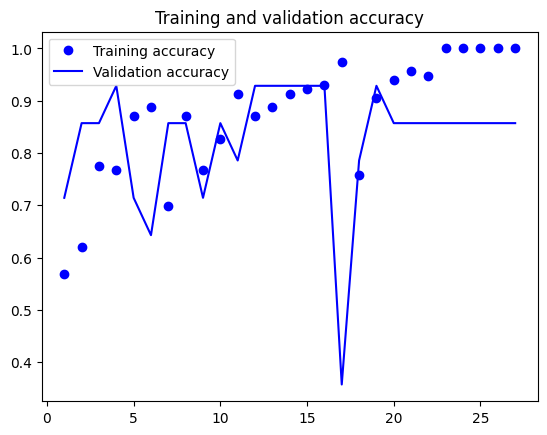

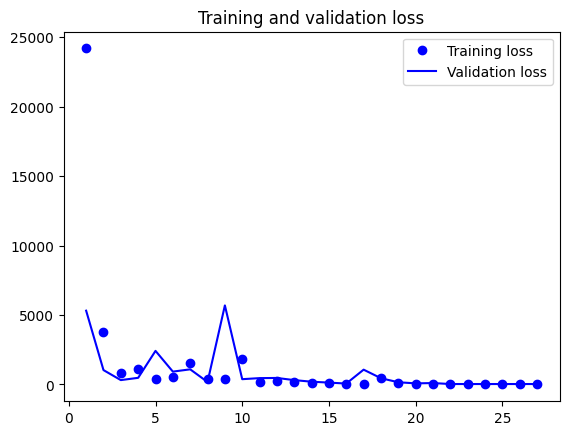

In [ ]:
accuracy = history.history["binary_accuracy"]
val_accuracy = history.history["val_binary_accuracy"]
loss = history.history["loss"]
val_loss = history.history["val_loss"]
epochs = range(1, len(accuracy) + 1)
plt.plot(epochs, accuracy, "bo", label="Training accuracy")
plt.plot(epochs, val_accuracy, "b", label="Validation accuracy")
plt.title("Training and validation accuracy")
plt.legend()
plt.figure()
plt.plot(epochs, loss, "bo", label="Training loss")
plt.plot(epochs, val_loss, "b", label="Validation loss")
plt.title("Training and validation loss")
plt.legend()
plt.show()

## Evaluate model

In [ ]:
test_loss, test_acc = model.evaluate(test_dataset)
print(f"Test accuracy: {test_acc:.3f}")

1/1 [==============================] - 0s 164ms/step - loss: 367.8205 - binary_accuracy: 0.8750
Test accuracy: 0.875


In [ ]:
predictions = np.array([])
labels =  np.array([])
for x, y in test_dataset:
  predictions = model.predict(x)
  labels = np.concatenate([labels, y])

1/1 [==============================] - 0s 112ms/step


In [ ]:
tf.math.confusion_matrix(labels=labels, predictions=predictions).numpy()

array([[10,  1],
       [ 1,  4]], dtype=int32)

## Grad-CAM
Source code: https://keras.io/examples/vision/grad_cam/

In [ ]:
def get_img_array(img_path, size):
    # `img` is a PIL image of size 299x299
    img = keras.utils.load_img(img_path, target_size=size)
    # `array` is a float32 Numpy array of shape (299, 299, 3)
    array = keras.utils.img_to_array(img)
    # We add a dimension to transform our array into a "batch"
    # of size (1, 299, 299, 3)
    array = np.expand_dims(array, axis=0)
    return array


def make_gradcam_heatmap(img_array, model, pred_index=None):
    # First, we create a model that maps the input image to the activations
    # of the last conv layer as well as the output predictions
    # grad_model = keras.models.Model(
    #     model.inputs, [model.get_layer(last_conv_layer_name).output, model.output]
    # )

    grad_model = keras.models.Model(
        model.inputs, [model.layers[1].output, model.output]
    )

    # Then, we compute the gradient of the top predicted class for our input image
    # with respect to the activations of the last conv layer
    with tf.GradientTape() as tape:
        last_conv_layer_output, preds = grad_model(img_array)
        if pred_index is None:
            pred_index = tf.argmax(preds[0])
        class_channel = preds[:, pred_index]

    # This is the gradient of the output neuron (top predicted or chosen)
    # with regard to the output feature map of the last conv layer
    grads = tape.gradient(class_channel, last_conv_layer_output)

    # This is a vector where each entry is the mean intensity of the gradient
    # over a specific feature map channel
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    # We multiply each channel in the feature map array
    # by "how important this channel is" with regard to the top predicted class
    # then sum all the channels to obtain the heatmap class activation
    last_conv_layer_output = last_conv_layer_output[0]
    heatmap = last_conv_layer_output @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)

    # For visualization purpose, we will also normalize the heatmap between 0 & 1
    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    return heatmap.numpy()


### Caucasian examples

30288_(1804).dcm.jpg
1/1 [==============================] - 0s 26ms/step
Predicted: [0.]


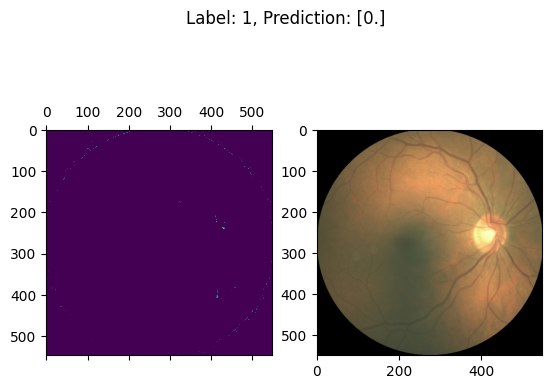

70295_(2009).dcm.jpg
1/1 [==============================] - 0s 24ms/step
Predicted: [1.]


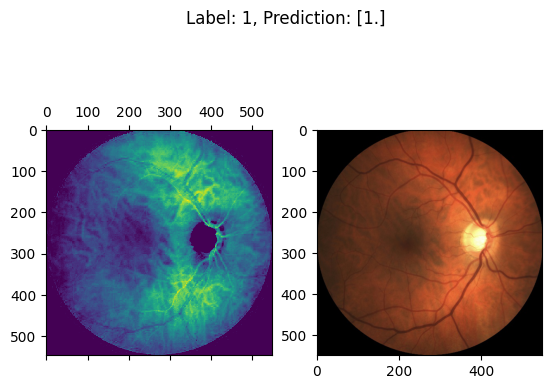

69274_(1748).dcm.jpg
1/1 [==============================] - 0s 25ms/step
Predicted: [1.]


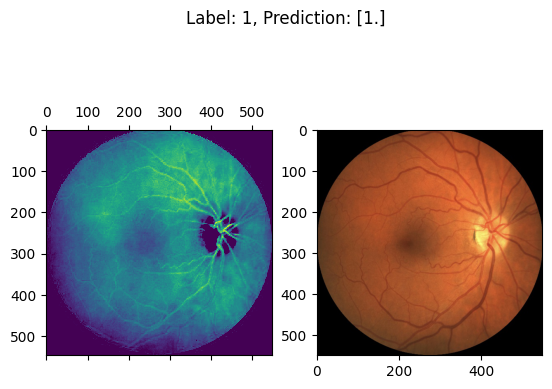

87_(2034).dcm.jpg
1/1 [==============================] - 0s 25ms/step
Predicted: [1.]


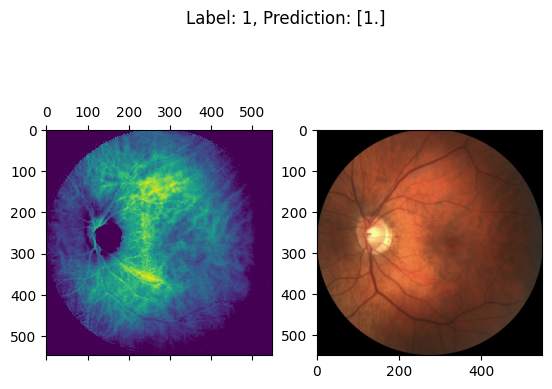

920472_(1096).dcm.jpg
1/1 [==============================] - 0s 25ms/step
Predicted: [1.]


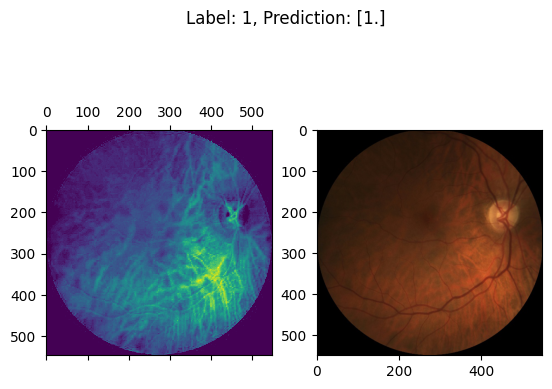

In [ ]:
# Prepare image
base_dir = '/content/drive/My Drive/MSc Data Science/Dissertation/Data/HEI-MED/ethnicity-classifier/test/CAUCASIAN'
caucasian_imgs = os.listdir(base_dir)

for i in range(0, 5):
  img_path = os.path.join(base_dir, caucasian_imgs[i])
  img_array = get_img_array(img_path, size=(549, 549))

  # Remove last layer's softmax
  model.layers[-1].activation = None

  # Print filename
  print(caucasian_imgs[i])

  # Print what the top predicted class is
  preds = model.predict(img_array)
  # print("Predicted:", decode_predictions(preds, top=1)[0])
  print("Predicted:", preds[0])

  # Generate class activation heatmap
  heatmap = make_gradcam_heatmap(img_array, model)

  # Display heatmap
  # plt.matshow(heatmap)
  fig, ax = plt.subplots(1, 2)
  ax[0].matshow(heatmap)
  ax[1].imshow(keras.utils.load_img(img_path, target_size=(549,549)))
  fig.suptitle('Label: {}, Prediction: {}'.format(1, np.round(preds[0], 1)))
  plt.show()

### African examples

(00000188).jpg
1/1 [==============================] - 0s 23ms/step
Predicted: [0.]


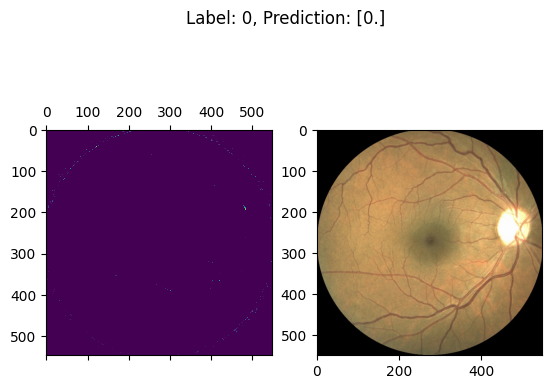

(00000188).jpg
1/1 [==============================] - 0s 27ms/step
Predicted: [8.332493e-12]


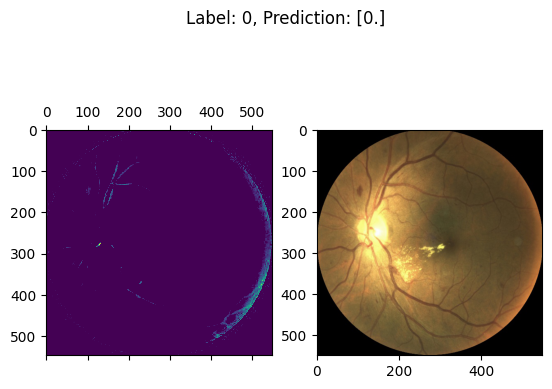

(00000188).jpg
1/1 [==============================] - 0s 24ms/step
Predicted: [0.]


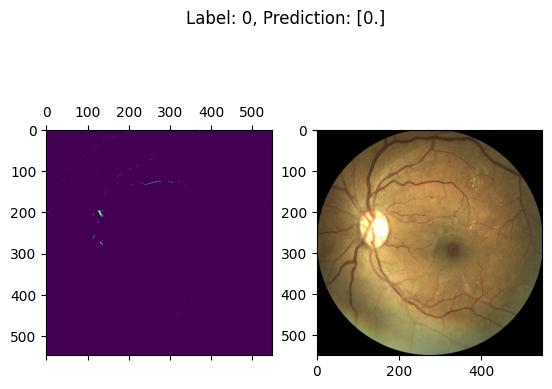

(00000188).jpg
1/1 [==============================] - 0s 22ms/step
Predicted: [5.752659e-19]


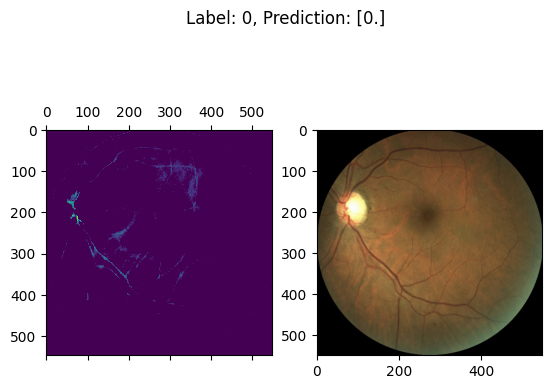

(00000188).jpg
1/1 [==============================] - 0s 26ms/step
Predicted: [1.]


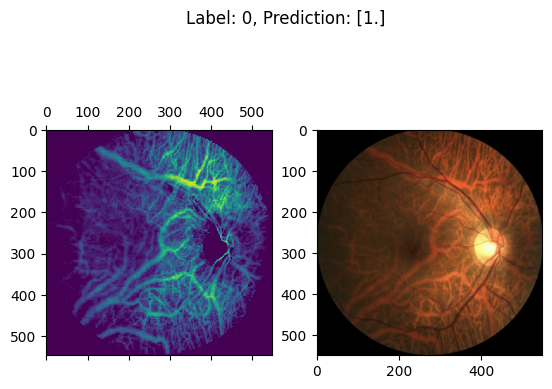

In [ ]:
# Prepare image
base_dir = '/content/drive/My Drive/MSc Data Science/Dissertation/Data/HEI-MED/ethnicity-classifier/test/AFRICAN'
african_imgs = os.listdir(base_dir)

for i in range(0, 5):
  img_path = os.path.join(base_dir, african_imgs[i])
  img_array = get_img_array(img_path, size=(549, 549))

  # Remove last layer's softmax
  model.layers[-1].activation = None

  # Print filename
  print(african_imgs[0])

  # Print what the top predicted class is
  preds = model.predict(img_array)
  # print("Predicted:", decode_predictions(preds, top=1)[0])
  print("Predicted:", preds[0])

  # Generate class activation heatmap
  heatmap = make_gradcam_heatmap(img_array, model)

  # Display heatmap
  # plt.matshow(heatmap)
  fig, ax = plt.subplots(1, 2)
  ax[0].matshow(heatmap)
  ax[1].imshow(keras.utils.load_img(img_path, target_size=(549,549)))
  fig.suptitle('Label: {}, Prediction: {}'.format(0, np.round(preds[0], 1)))
  plt.show()

## Test on DRIONS-DB
We would expect to see all images classified as Caucasian here (http://www.ia.uned.es/~ejcarmona/DRIONS-DB.html).

### DRIONS-DB Pre-Processing
Make this consistent with HEI-MED

In [ ]:
# Citation needed
def circle_crop_v2(img):
    """
    Create circular crop around image centre
    """
    img = cv2.imread(img)

    height, width, depth = img.shape
    largest_side = np.max((height, width))
    img = cv2.resize(img, (largest_side, largest_side))

    height, width, depth = img.shape

    x = int(width / 2)
    y = int(height / 2)
    r = np.amin((x, y))

    circle_img = np.zeros((height, width), np.uint8)
    cv2.circle(circle_img, (x, y), int(r), 1, thickness=-1)
    img = cv2.bitwise_and(img, img, mask=circle_img)

    new_size = int(largest_side/4)
    # new_size = 549
    img = cv2.resize(img, (new_size, new_size)) # Make image smaller

    return img

In [ ]:
img_path = '/content/drive/My Drive/MSc Data Science/Dissertation/Datasets/DRIONS-DB/images/image_110.jpg'
img = cv2.imread(img_path)
img.shape

(137, 137, 3)

In [ ]:
src_dir = '/content/drive/My Drive/MSc Data Science/Dissertation/Datasets/DRIONS-DB/images'
dest_dir = '/content/drive/My Drive/MSc Data Science/Dissertation/Data/HEI-MED/ethnicity-classifier/drions_test/CAUCASIAN'

for img in glob.glob(src_dir+'/*.jpg'):
# for img in os.listdir(src_dir):
  new_img = circle_crop_v2(os.path.join(src_dir, img))
  cv2.imwrite(os.path.join(dest_dir, img), new_img)

### Test model

In [3]:
inputs = keras.Input(shape=(549, 549, 3))
x = layers.Conv2D(filters=32, kernel_size=3, activation="relu")(inputs)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=64, kernel_size=3, activation="relu")(inputs)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Flatten()(x)
# x = layers.Dropout(0.2)(x) # Add dropout to reduce overfitting
outputs = layers.Dense(1, activation="sigmoid")(x)
model = keras.Model(inputs=inputs, outputs=outputs)

In [4]:
model.compile(loss="binary_crossentropy",
              optimizer="rmsprop",
              # metrics=["accuracy"])
              metrics=["binary_accuracy"])

In [5]:
model.load_weights('/content/drive/My Drive/MSc Data Science/Dissertation/Models/ethnicity_clf_cnn.keras')

In [ ]:
new_base_dir = pathlib.Path('/content/drive/My Drive/MSc Data Science/Dissertation/Data/HEI-MED/ethnicity-classifier/')

drions_dataset = image_dataset_from_directory(
    new_base_dir / 'drions_test',
    image_size=(549, 549),
    batch_size=32)

Found 91 files belonging to 2 classes.


In [ ]:
drions_loss, drions_acc = model.evaluate(drions_dataset)
print(f"Test accuracy on DRIONS-DB: {drions_acc:.3f}")

3/3 [==============================] - 1s 105ms/step - loss: 6.7220 - binary_accuracy: 0.9780
Test accuracy on DRIONS-DB: 0.978


In [ ]:
predictions = np.array([])
labels =  np.array([])
for x, y in drions_dataset:
  # predictions = model.predict(x)
  predictions = np.concatenate([predictions, model.predict(x).flatten()])
  labels = np.concatenate([labels, y])

1/1 [==============================] - 0s 135ms/step


In [ ]:
tf.math.confusion_matrix(labels=labels, predictions=predictions).numpy()

array([[ 0,  0],
       [ 2, 89]], dtype=int32)

In [ ]:
np.unique(predictions)

array([0., 1.])

### CAMs for misclassified samples

In [ ]:
base_dir = '/content/drive/My Drive/MSc Data Science/Dissertation/Data/HEI-MED/ethnicity-classifier/drions_test/CAUCASIAN'
imgs = os.listdir(base_dir)

preds_dict = {}

for i in range(len(imgs)):
  img_path = os.path.join(base_dir, imgs[i])
  img_array = get_img_array(img_path, size=(549, 549))

  # # Remove last layer's softmax
  model.layers[-1].activation = None

  # Print what the top predicted class is
  preds = model.predict(img_array)

  preds_dict[imgs[i]] = np.round(preds[0], 1)

1/1 [==============================] - 0s 20ms/step


In [ ]:
result = {key:value for (key, value) in preds_dict.items() if np.round(value, 1) != 1}
print(result)

{'image_084.jpg': array([0.], dtype=float32), 'image_019.jpg': array([0.], dtype=float32)}


/content/drive/My Drive/MSc Data Science/Dissertation/Data/HEI-MED/ethnicity-classifier/drions_test/CAUCASIAN/image_084.jpg
1/1 [==============================] - 0s 20ms/step
Predicted: [0.]


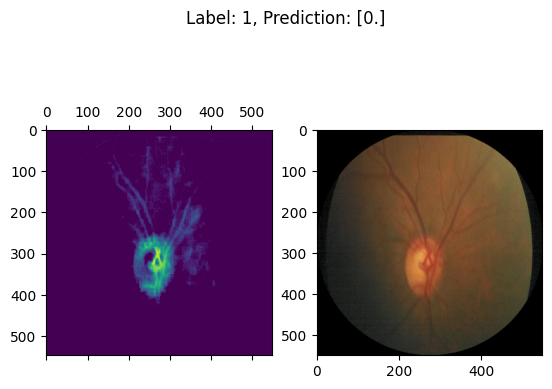

/content/drive/My Drive/MSc Data Science/Dissertation/Data/HEI-MED/ethnicity-classifier/drions_test/CAUCASIAN/image_084.jpg
1/1 [==============================] - 0s 22ms/step
Predicted: [0.]


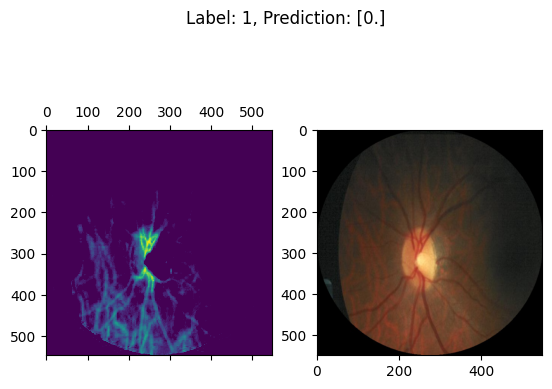

In [ ]:
# Prepare image
base_dir = '/content/drive/My Drive/MSc Data Science/Dissertation/Data/HEI-MED/ethnicity-classifier/drions_test/CAUCASIAN'
imgs = [os.path.join(base_dir, 'image_084.jpg'), os.path.join(base_dir, 'image_019.jpg')]

for i in range(len(imgs)):
  img_path = os.path.join(base_dir, imgs[i])
  img_array = get_img_array(img_path, size=(549, 549))

  # Remove last layer's softmax
  model.layers[-1].activation = None

  # Print filename
  print(imgs[0])

  # Print what the top predicted class is
  preds = model.predict(img_array)
  # print("Predicted:", decode_predictions(preds, top=1)[0])
  print("Predicted:", preds[0])

  # Generate class activation heatmap
  heatmap = make_gradcam_heatmap(img_array, model)

  # Display heatmap
  # plt.matshow(heatmap)
  fig, ax = plt.subplots(1, 2)
  ax[0].matshow(heatmap)
  ax[1].imshow(keras.utils.load_img(img_path, target_size=(549,549)))
  fig.suptitle('Label: {}, Prediction: {}'.format(1, np.round(preds[0], 1)))
  plt.show()

### CAMs for correctly classified samples

image_084.jpg
1/1 [==============================] - 0s 33ms/step
Predicted: [1.]


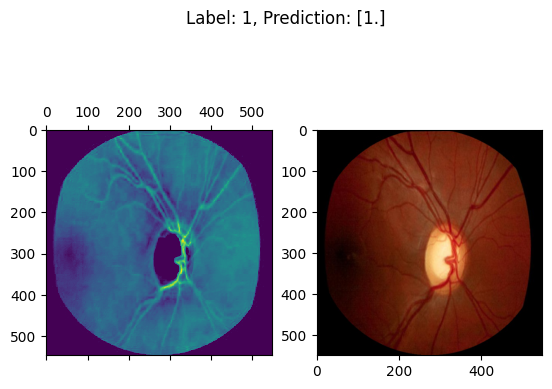

image_084.jpg
1/1 [==============================] - 0s 39ms/step
Predicted: [1.]


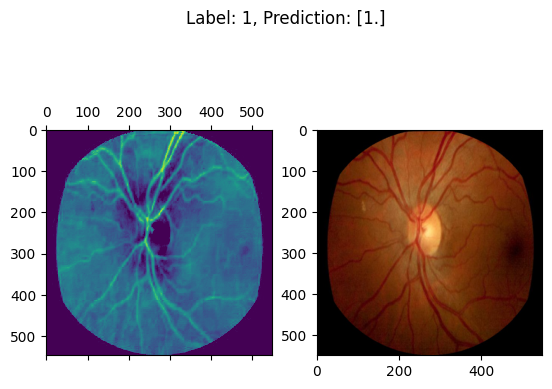

image_084.jpg
1/1 [==============================] - 0s 38ms/step
Predicted: [1.]


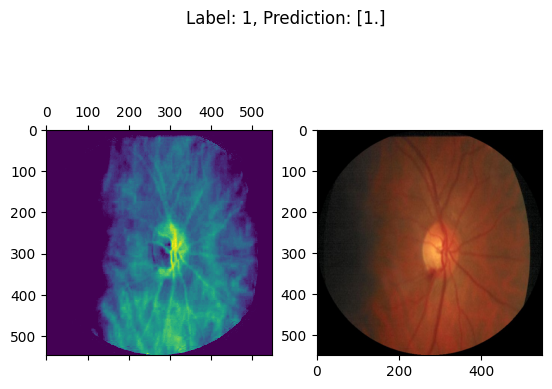

image_084.jpg
1/1 [==============================] - 0s 36ms/step
Predicted: [1.]


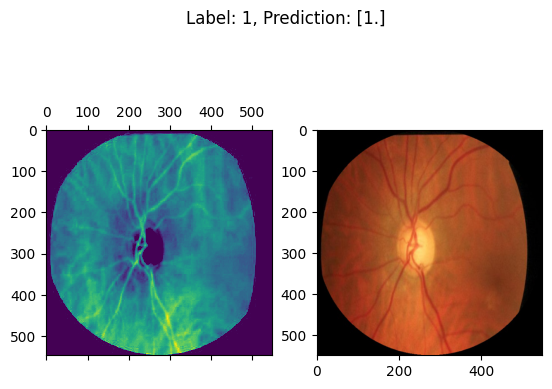

image_084.jpg
1/1 [==============================] - 0s 22ms/step
Predicted: [1.]


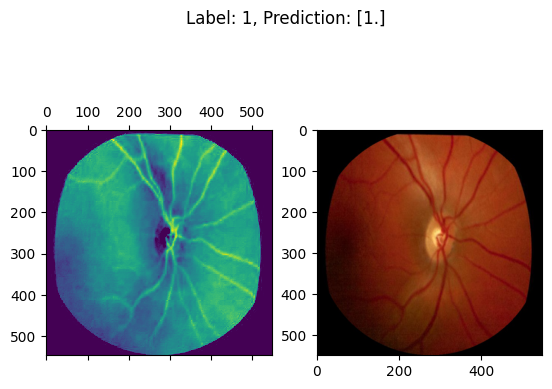

In [ ]:
# Prepare image
base_dir = '/content/drive/My Drive/MSc Data Science/Dissertation/Data/HEI-MED/ethnicity-classifier/drions_test/CAUCASIAN'
# imgs = [os.path.join(base_dir, 'image_084.jpg'), os.path.join(base_dir, 'image_019.jpg')]
imgs = os.listdir(base_dir)

# for i in range(len(imgs)):
for i in range(0, 6):
  if imgs[i] not in ['image_084.jpg', 'image_019.jpg']:
    img_path = os.path.join(base_dir, imgs[i])
    img_array = get_img_array(img_path, size=(549, 549))

    # Remove last layer's softmax
    model.layers[-1].activation = None

    # Print filename
    print(imgs[0])

    # Print what the top predicted class is
    preds = model.predict(img_array)
    # print("Predicted:", decode_predictions(preds, top=1)[0])
    print("Predicted:", preds[0])

    # Generate class activation heatmap
    heatmap = make_gradcam_heatmap(img_array, model)

    # Display heatmap
    # plt.matshow(heatmap)
    fig, ax = plt.subplots(1, 2)
    ax[0].matshow(heatmap)
    ax[1].imshow(keras.utils.load_img(img_path, target_size=(549,549)))
    fig.suptitle('Label: {}, Prediction: {}'.format(1, np.round(preds[0], 1)))
    plt.show()

# Ethnicity Classifier - Multi-class (African/Caucasian/Hispanic)

## Split images into train, val, and test

In [ ]:
os.mkdir('/content/drive/My Drive/MSc Data Science/Dissertation/Data/HEI-MED/ethnicity-classifier-mc/')

In [ ]:
indir = '/content/drive/My Drive/MSc Data Science/Dissertation/Data/HEI-MED/processed-data-ethnicity/'
outdir = '/content/drive/My Drive/MSc Data Science/Dissertation/Data/HEI-MED/ethnicity-classifier-mc/'

In [ ]:
splitfolders.ratio(indir, output=outdir,
    seed=1337, ratio=(.8, .1, .1), group_prefix=None, move=False)

Copying files: 169 files [00:02, 73.04 files/s]


In [ ]:
for folder in os.listdir(outdir):
  print(folder)
  for ethnicity in os.listdir(os.path.join(outdir, folder)):
    print(ethnicity + ': ' + str(len(os.listdir(os.path.join(outdir, folder, ethnicity)))) + ' samples')

train
AFRICAN: 83 samples
CAUCASIAN: 33 samples
HISPANIC: 15 samples
UNKNOWN: 3 samples
val
AFRICAN: 10 samples
CAUCASIAN: 4 samples
HISPANIC: 1 samples
UNKNOWN: 0 samples
test
AFRICAN: 11 samples
CAUCASIAN: 5 samples
HISPANIC: 3 samples
UNKNOWN: 1 samples


## Read in train, val and test sets
Removed Unknown - this will be a multi-class classification between African, Caucasian, and Hispanic.

In [ ]:
new_base_dir = pathlib.Path('/content/drive/My Drive/MSc Data Science/Dissertation/Data/HEI-MED/ethnicity-classifier-mc/')

train_dataset = image_dataset_from_directory(
    new_base_dir / 'train',
    image_size=(549, 549),
    batch_size=32)
validation_dataset = image_dataset_from_directory(
    new_base_dir / 'val',
    image_size=(549, 549),
    batch_size=32)
test_dataset = image_dataset_from_directory(
    new_base_dir / 'test',
    image_size=(549, 549),
    batch_size=32)

Found 131 files belonging to 3 classes.
Found 15 files belonging to 3 classes.
Found 19 files belonging to 3 classes.


In [ ]:
for x, y in test_dataset:
  print(y)

tf.Tensor([1 0 0 0 1 0 2 0 2 0 1 0 1 0 0 0 0 2 1], shape=(19,), dtype=int32)


0 = AFRICAN, 1 = CAUCASIAN, 2 = HISPANIC

## Build and compile model

In [ ]:
inputs = keras.Input(shape=(549, 549, 3))
x = layers.Conv2D(filters=32, kernel_size=3, activation="relu")(inputs)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=64, kernel_size=3, activation="relu")(inputs)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Flatten()(x)
# x = layers.Dropout(0.2)(x) # Add dropout to reduce overfitting
outputs = layers.Dense(3, activation="softmax")(x) # 3 classes
model = keras.Model(inputs=inputs, outputs=outputs)

In [ ]:
model.compile(loss="sparse_categorical_crossentropy", # Multi-class classification with integer labels (DLWP Chapter 8)
              optimizer="rmsprop",
              # metrics=["accuracy"])
              metrics=["sparse_categorical_accuracy"])

## Train model

In [ ]:
callbacks = [
    keras.callbacks.ModelCheckpoint(
        filepath="/content/drive/My Drive/MSc Data Science/Dissertation/Models/ethnicity_clf_cnn_mc.keras",
        save_best_only=True,
        monitor="val_loss"),
    keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, mode='min', start_from_epoch=20)
]
history = model.fit(
    train_dataset,
    epochs=40,
    validation_data=validation_dataset,
    callbacks=callbacks)

Epoch 1/40
5/5 [==============================] - 4s 575ms/step - loss: 42542.5742 - sparse_categorical_accuracy: 0.4275 - val_loss: 4593.0498 - val_sparse_categorical_accuracy: 0.4667
Epoch 2/40
5/5 [==============================] - 2s 217ms/step - loss: 4744.6240 - sparse_categorical_accuracy: 0.5878 - val_loss: 30594.2500 - val_sparse_categorical_accuracy: 0.0667
Epoch 3/40
5/5 [==============================] - 2s 324ms/step - loss: 6982.8774 - sparse_categorical_accuracy: 0.6260 - val_loss: 956.8832 - val_sparse_categorical_accuracy: 0.8000
Epoch 4/40
5/5 [==============================] - 2s 204ms/step - loss: 754.4243 - sparse_categorical_accuracy: 0.7786 - val_loss: 5875.7847 - val_sparse_categorical_accuracy: 0.6667
Epoch 5/40
5/5 [==============================] - 2s 258ms/step - loss: 2343.7952 - sparse_categorical_accuracy: 0.6641 - val_loss: 1014.5816 - val_sparse_categorical_accuracy: 0.8000
Epoch 6/40
5/5 [==============================] - 2s 247ms/step - loss: 2121.258

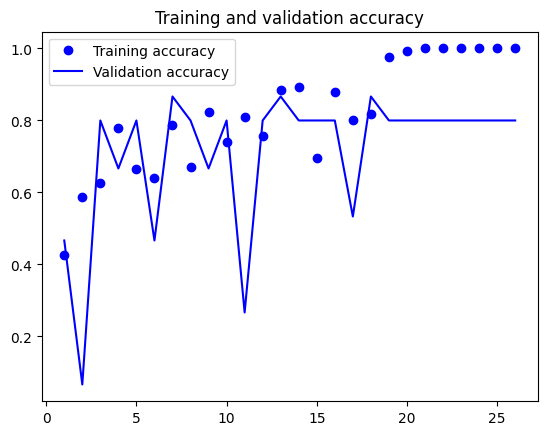

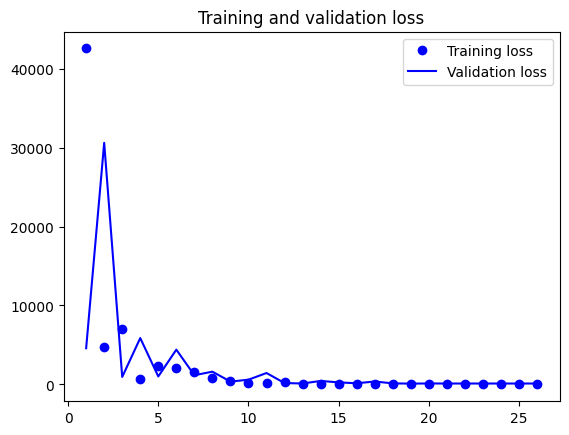

In [ ]:
accuracy = history.history["sparse_categorical_accuracy"]
val_accuracy = history.history["val_sparse_categorical_accuracy"]
loss = history.history["loss"]
val_loss = history.history["val_loss"]
epochs = range(1, len(accuracy) + 1)
plt.plot(epochs, accuracy, "bo", label="Training accuracy")
plt.plot(epochs, val_accuracy, "b", label="Validation accuracy")
plt.title("Training and validation accuracy")
plt.legend()
plt.figure()
plt.plot(epochs, loss, "bo", label="Training loss")
plt.plot(epochs, val_loss, "b", label="Validation loss")
plt.title("Training and validation loss")
plt.legend()
plt.show()

## Evaluate model

In [ ]:
test_loss, test_acc = model.evaluate(test_dataset)
print(f"Test accuracy: {test_acc:.3f}")

1/1 [==============================] - 0s 194ms/step - loss: 364.0780 - sparse_categorical_accuracy: 0.6316
Test accuracy: 0.632


# Ethnicity Classifier - Binary (Light/Dark)
Light = Caucasian, Dark = African, Hispanic

## Read in train, val and test sets

In [ ]:
new_base_dir = pathlib.Path('/content/drive/My Drive/MSc Data Science/Dissertation/Data/HEI-MED/ethnicity-classifier-light-dark/')

train_dataset = image_dataset_from_directory(
    new_base_dir / 'train',
    image_size=(549, 549),
    batch_size=32)
validation_dataset = image_dataset_from_directory(
    new_base_dir / 'val',
    image_size=(549, 549),
    batch_size=32)
test_dataset = image_dataset_from_directory(
    new_base_dir / 'test',
    image_size=(549, 549),
    batch_size=32)

Found 131 files belonging to 2 classes.
Found 15 files belonging to 2 classes.
Found 19 files belonging to 2 classes.


In [ ]:
for x, y in test_dataset:
  print(y)

tf.Tensor([0 0 0 0 0 0 0 0 1 0 1 0 0 1 0 1 0 1 0], shape=(19,), dtype=int32)


0 = DARK, 1 = LIGHT

## Build and compile model

In [ ]:
inputs = keras.Input(shape=(549, 549, 3))
x = layers.Conv2D(filters=32, kernel_size=3, activation="relu")(inputs)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=64, kernel_size=3, activation="relu")(inputs)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Flatten()(x)
# x = layers.Dropout(0.2)(x) # Add dropout to reduce overfitting
outputs = layers.Dense(1, activation="sigmoid")(x) # 2 classes
model = keras.Model(inputs=inputs, outputs=outputs)

In [ ]:
model.compile(loss="binary_crossentropy", # Multi-class classification with integer labels (DLWP Chapter 8)
              optimizer="rmsprop",
              # metrics=["accuracy"])
              metrics=["binary_accuracy"])

## Train model

In [ ]:
callbacks = [
    keras.callbacks.ModelCheckpoint(
        filepath="/content/drive/My Drive/MSc Data Science/Dissertation/Models/ethnicity_clf_cnn_light_dark.keras",
        save_best_only=True,
        monitor="val_loss"),
    keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, mode='min', start_from_epoch=20)
]
history = model.fit(
    train_dataset,
    epochs=40,
    validation_data=validation_dataset,
    callbacks=callbacks)

Epoch 1/40
5/5 [==============================] - 4s 466ms/step - loss: 28786.7090 - binary_accuracy: 0.5496 - val_loss: 2232.5852 - val_binary_accuracy: 0.7333
Epoch 2/40
5/5 [==============================] - 2s 314ms/step - loss: 4154.7207 - binary_accuracy: 0.6565 - val_loss: 716.3793 - val_binary_accuracy: 0.8000
Epoch 3/40
5/5 [==============================] - 2s 208ms/step - loss: 2918.5728 - binary_accuracy: 0.6870 - val_loss: 4173.1963 - val_binary_accuracy: 0.7333
Epoch 4/40
5/5 [==============================] - 2s 248ms/step - loss: 893.4849 - binary_accuracy: 0.8702 - val_loss: 326.3553 - val_binary_accuracy: 0.8667
Epoch 5/40
5/5 [==============================] - 2s 216ms/step - loss: 341.9901 - binary_accuracy: 0.8855 - val_loss: 3875.2156 - val_binary_accuracy: 0.2667
Epoch 6/40
5/5 [==============================] - 2s 206ms/step - loss: 2807.3906 - binary_accuracy: 0.6947 - val_loss: 411.7779 - val_binary_accuracy: 0.9333
Epoch 7/40
5/5 [============================

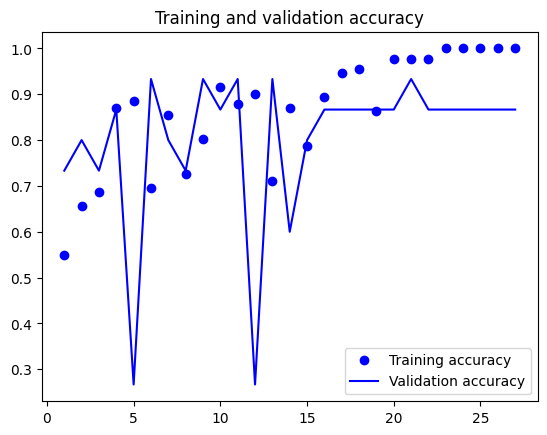

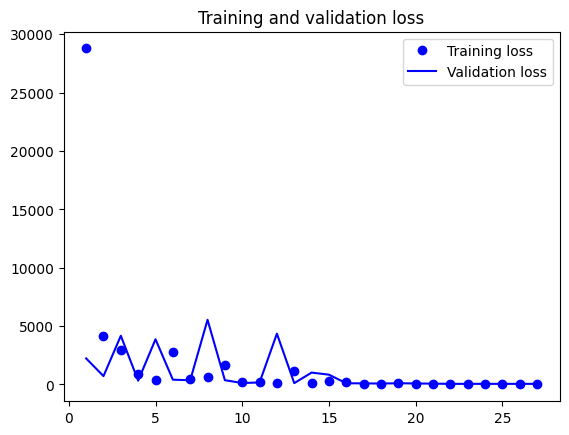

In [ ]:
accuracy = history.history["binary_accuracy"]
val_accuracy = history.history["val_binary_accuracy"]
loss = history.history["loss"]
val_loss = history.history["val_loss"]
epochs = range(1, len(accuracy) + 1)
plt.plot(epochs, accuracy, "bo", label="Training accuracy")
plt.plot(epochs, val_accuracy, "b", label="Validation accuracy")
plt.title("Training and validation accuracy")
plt.legend()
plt.figure()
plt.plot(epochs, loss, "bo", label="Training loss")
plt.plot(epochs, val_loss, "b", label="Validation loss")
plt.title("Training and validation loss")
plt.legend()
plt.show()

## Evaluate model

In [ ]:
model.load_weights('/content/drive/My Drive/MSc Data Science/Dissertation/Models/ethnicity_clf_cnn_light_dark.keras')

In [ ]:
test_loss, test_acc = model.evaluate(test_dataset)
print(f"Test accuracy: {test_acc:.3f}")

1/1 [==============================] - 0s 182ms/step - loss: 229.1259 - binary_accuracy: 0.7368
Test accuracy: 0.737


In [ ]:
predictions = np.array([])
labels =  np.array([])
for x, y in test_dataset:
  predictions = model.predict(x)
  labels = np.concatenate([labels, y])

1/1 [==============================] - 8s 8s/step


In [ ]:
tf.math.confusion_matrix(labels=labels, predictions=predictions).numpy()

array([[10,  4],
       [ 1,  4]], dtype=int32)

### Light examples

30288_(1804).dcm.jpg
1/1 [==============================] - 0s 32ms/step
Predicted: [0.]


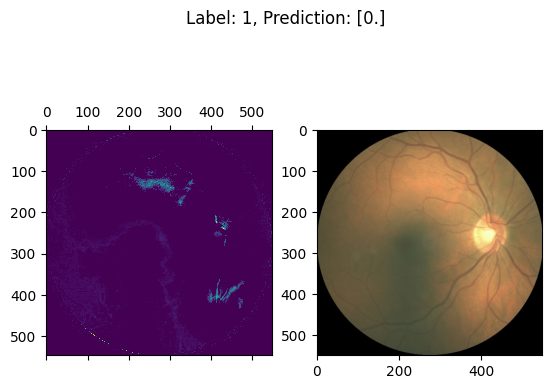

70295_(2009).dcm.jpg
1/1 [==============================] - 0s 33ms/step
Predicted: [1.]


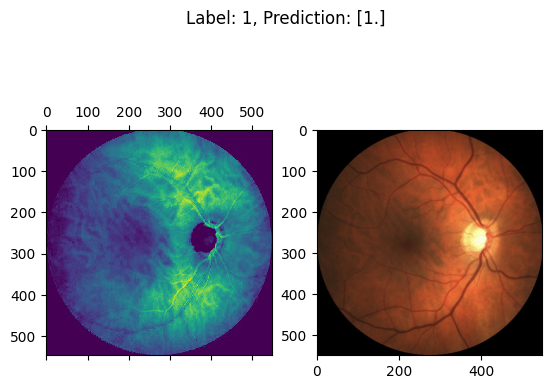

87_(2034).dcm.jpg
1/1 [==============================] - 0s 22ms/step
Predicted: [1.]


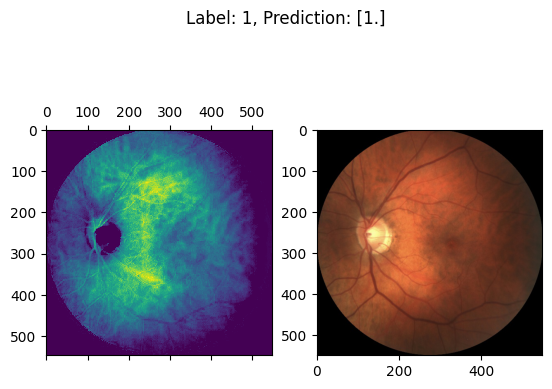

69274_(1748).dcm.jpg
1/1 [==============================] - 0s 26ms/step
Predicted: [1.]


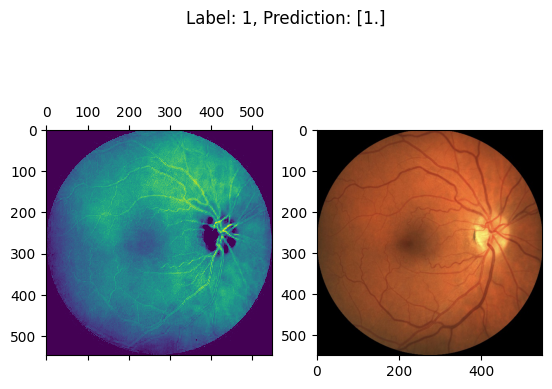

920472_(1096).dcm.jpg
1/1 [==============================] - 0s 34ms/step
Predicted: [1.]


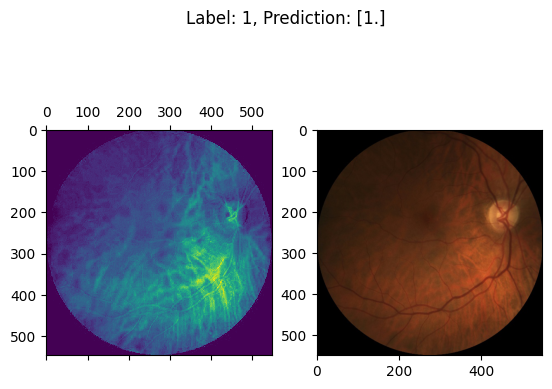

In [ ]:
# Prepare image
base_dir = '/content/drive/My Drive/MSc Data Science/Dissertation/Data/HEI-MED/ethnicity-classifier-light-dark/test/LIGHT'
caucasian_imgs = os.listdir(base_dir)

# for i in range(0, 5):
for i in range(len(caucasian_imgs)):
  img_path = os.path.join(base_dir, caucasian_imgs[i])
  img_array = get_img_array(img_path, size=(549, 549))

  # Remove last layer's softmax
  model.layers[-1].activation = None

  # Print filename
  print(caucasian_imgs[i])

  # Print what the top predicted class is
  preds = model.predict(img_array)
  # print("Predicted:", decode_predictions(preds, top=1)[0])
  print("Predicted:", preds[0])

  # Generate class activation heatmap
  heatmap = make_gradcam_heatmap(img_array, model)

  # Display heatmap
  # plt.matshow(heatmap)
  fig, ax = plt.subplots(1, 2)
  ax[0].matshow(heatmap)
  ax[1].imshow(keras.utils.load_img(img_path, target_size=(549,549)))
  fig.suptitle('Label: {}, Prediction: {}'.format(1, np.round(preds[0], 1)))
  plt.show()

### Dark examples

In [ ]:
# Prepare image
base_dir = '/content/drive/My Drive/MSc Data Science/Dissertation/Data/HEI-MED/ethnicity-classifier-light-dark/test/DARK'
african_imgs = os.listdir(base_dir)

# for i in range(0, 5):
for i in range(len(african_imgs)):
  img_path = os.path.join(base_dir, african_imgs[i])
  img_array = get_img_array(img_path, size=(549, 549))

  # Remove last layer's softmax
  model.layers[-1].activation = None

  # Print filename
  print(african_imgs[0])

  # Print what the top predicted class is
  preds = model.predict(img_array)
  # print("Predicted:", decode_predictions(preds, top=1)[0])
  print("Predicted:", preds[0])

  # Generate class activation heatmap
  heatmap = make_gradcam_heatmap(img_array, model)

  # Display heatmap
  # plt.matshow(heatmap)
  fig, ax = plt.subplots(1, 2)
  ax[0].matshow(heatmap)
  ax[1].imshow(keras.utils.load_img(img_path, target_size=(549,549)))
  fig.suptitle('Label: {}, Prediction: {}'.format(0, np.round(preds[0], 1)))
  plt.show()

Output hidden; open in https://colab.research.google.com to view.

# Deep Transfer Model for Ethnicity Classifier
Paper: https://www.mdpi.com/2075-4418/12/7/1714<br>
Tutorial: https://khawlajlassi.medium.com/a-guide-to-transfer-learning-with-keras-using-densenet201-48c617ceb2e2

## Read in train, val and test sets

In [ ]:
new_base_dir = pathlib.Path('/content/drive/My Drive/MSc Data Science/Dissertation/Data/HEI-MED/ethnicity-classifier/')

train_dataset = image_dataset_from_directory(
    new_base_dir / 'train',
    image_size=(549, 549),
    batch_size=32)
validation_dataset = image_dataset_from_directory(
    new_base_dir / 'val',
    image_size=(549, 549),
    batch_size=32)
test_dataset = image_dataset_from_directory(
    new_base_dir / 'test',
    image_size=(549, 549),
    batch_size=32)

Found 116 files belonging to 2 classes.
Found 14 files belonging to 2 classes.
Found 16 files belonging to 2 classes.


## Build and compile model

In [ ]:
# Base model: DenseNet201 pre-trained on ImageNet
base_model = keras.applications.DenseNet201(include_top=False,
                                            weights='imagenet',
                                            input_shape=(549,549,3),
                                            pooling='max')

In [ ]:
# Freeze the layers in the base model, i.e., prevent the weights from being further updated
base_model.trainable = False

In [ ]:
# Build model on top of base model
model = keras.Sequential()
model.add(base_model) # Add base model
model.add(layers.Flatten()) # Flatten output
# model.add(layers.Dense(128, activation='relu'))
# model.add(layers.BatchNormalization())
model.add(layers.Dense(64, activation='relu'))
model.add(layers.BatchNormalization())
model.add(layers.Dense(32, activation='relu'))
model.add(layers.BatchNormalization())
model.add(layers.Dropout(0.2))
model.add(layers.Dense(1, activation='sigmoid')) # Binary classifier

In [ ]:
# Compile the model
model.compile(loss='binary_crossentropy',
              optimizer=keras.optimizers.Adam(),
              metrics=['binary_accuracy'])

## Train model

In [ ]:
callbacks = [
    keras.callbacks.ModelCheckpoint(
        filepath="/content/drive/My Drive/MSc Data Science/Dissertation/Models/ethnicity_clf_densenet201_02_08.keras",
        save_best_only=True,
        monitor="val_loss"),
    keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, mode='min', start_from_epoch=20)
]
history = model.fit(
    train_dataset,
    epochs=30,
    validation_data=validation_dataset,
    callbacks=callbacks)

Epoch 1/30
4/4 [==============================] - 23s 3s/step - loss: 0.6839 - binary_accuracy: 0.6638 - val_loss: 2.5556 - val_binary_accuracy: 0.7143
Epoch 2/30
4/4 [==============================] - 6s 1s/step - loss: 0.5119 - binary_accuracy: 0.7414 - val_loss: 1.8378 - val_binary_accuracy: 0.7857
Epoch 3/30
4/4 [==============================] - 5s 917ms/step - loss: 0.3820 - binary_accuracy: 0.8362 - val_loss: 2.6086 - val_binary_accuracy: 0.7143
Epoch 4/30
4/4 [==============================] - 4s 867ms/step - loss: 0.2745 - binary_accuracy: 0.9052 - val_loss: 2.3250 - val_binary_accuracy: 0.7143
Epoch 5/30
4/4 [==============================] - 7s 2s/step - loss: 0.2607 - binary_accuracy: 0.8793 - val_loss: 1.6093 - val_binary_accuracy: 0.7857
Epoch 6/30
4/4 [==============================] - 6s 1s/step - loss: 0.2130 - binary_accuracy: 0.9397 - val_loss: 1.2859 - val_binary_accuracy: 0.7857
Epoch 7/30
4/4 [==============================] - 5s 1s/step - loss: 0.1906 - binary_ac

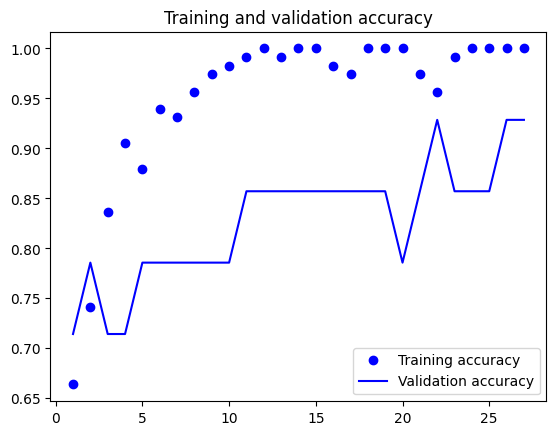

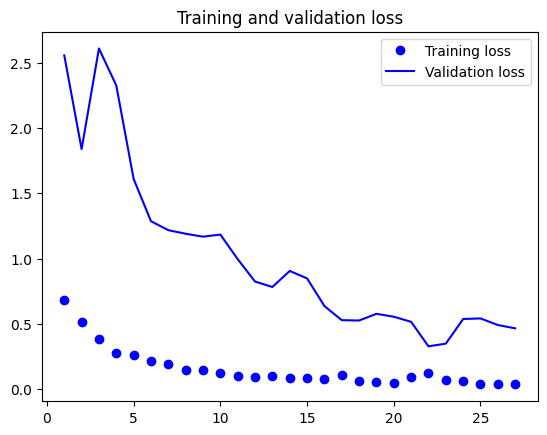

In [ ]:
accuracy = history.history["binary_accuracy"]
val_accuracy = history.history["val_binary_accuracy"]
loss = history.history["loss"]
val_loss = history.history["val_loss"]
epochs = range(1, len(accuracy) + 1)
plt.plot(epochs, accuracy, "bo", label="Training accuracy")
plt.plot(epochs, val_accuracy, "b", label="Validation accuracy")
plt.title("Training and validation accuracy")
plt.legend()
plt.figure()
plt.plot(epochs, loss, "bo", label="Training loss")
plt.plot(epochs, val_loss, "b", label="Validation loss")
plt.title("Training and validation loss")
plt.legend()
plt.show()

## Evaluate model

In [ ]:
test_loss, test_acc = model.evaluate(test_dataset)
print(f"Test accuracy: {test_acc:.3f}")

1/1 [==============================] - 1s 529ms/step - loss: 0.7558 - binary_accuracy: 0.8750
Test accuracy: 0.875
